<center><h1>Gender Classification</h1></center>

### Librairies 

In [1]:
import numpy as np
import random
import torch

from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics import F1Score
from torchvision.transforms import Compose, RandomHorizontalFlip, Normalize, RandomVerticalFlip
from torchvision.transforms.functional import center_crop
from functools import partial
from glob import glob
from PIL import Image
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import get_cosine_schedule_with_warmup

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 8

In [10]:
import pandas as pd

### Path definition

In [2]:
MAN_PATH = "faces/man"
WOMAN_PATH = "faces/woman"

### Retrieve images

In [3]:
man_files = glob(f"{MAN_PATH}/*.jpg")
woman_files = glob(f"{WOMAN_PATH}/*.jpg")
X = [np.asarray(Image.open(file)) for file in tqdm(man_files + woman_files)]
y = [1] * len(man_files) + [0] * len(woman_files)

  0%|          | 0/27167 [00:00<?, ?it/s]

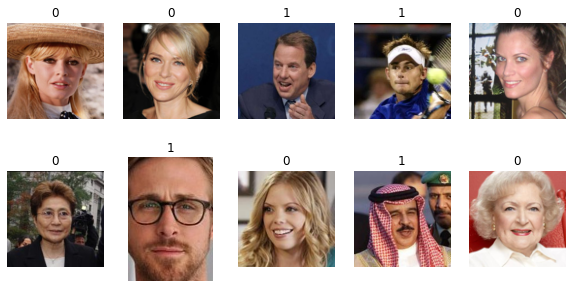

In [4]:
n, m = 2, 5
samples = random.sample(list(zip(X, y)), n*m)

fig, plts = plt.subplots(n, m)
fig.set_size_inches(10, 5)

for i in range(n):
    for j in range(m):
        plts[i, j].imshow(samples[i * m + j][0])
        plts[i, j].set_title(samples[i * m + j][1])
        plts[i, j].axis('off')

### Class distribution

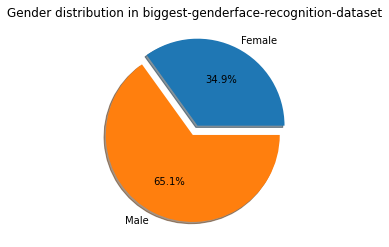

In [5]:
plt.pie([y.count(0), y.count(1)], autopct='%1.1f%%', labels=('Female', 'Male'), shadow=True, explode=(0.07, 0.05))
fig.patch.set_facecolor('white')  # Set the figure background to white
plt.title("Gender distribution in biggest-genderface-recognition-dataset")
plt.show()

### Train Test split

Text(0.5, 1.0, 'Gender distribution in Test set')

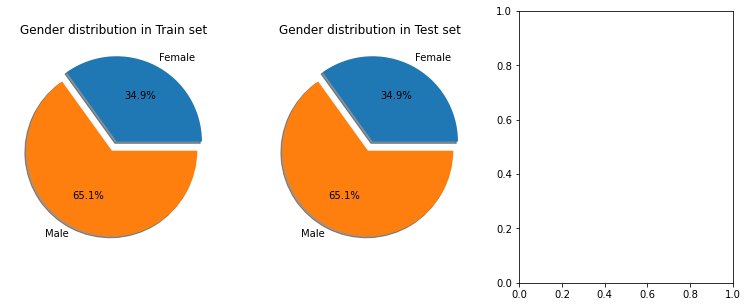

In [8]:
fig, plts = plt.subplots(1, 3)
fig.set_size_inches(13, 5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=112, stratify=y)
plts[0].pie([y_train.count(0), y_train.count(1)], autopct='%1.1f%%', labels=('Female', 'Male'), shadow=True, explode=(0.07, 0.05))
plts[0].set_title("Gender distribution in Train set")

plts[1].pie([y_test.count(0), y_test.count(1)], autopct='%1.1f%%', labels=('Female', 'Male'), shadow=True, explode=(0.07, 0.05))
plts[1].set_title("Gender distribution in Test set")

In [16]:
y_train_df = pd.DataFrame(y_train)
y_train_df.to_csv("y_train.csv")

y_test_df = pd.DataFrame(y_test)
y_test_df.to_csv("y_test.csv")

In [18]:
sets = ("Train", "Test")
set_quantity = {
    'Male': (y_train.count(1), y_test.count(1)),
    'Female': (y_train.count(0), y_test.count(0)),
}

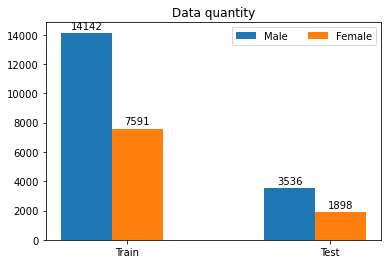

In [19]:
x = np.arange(len(sets))
width = 0.25
multiplier = 0.2

fig, ax = plt.subplots()  # Using fig and ax for better control and clarity

for attribute, measurement in set_quantity.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=2)
    multiplier += 1

ax.set_title("Data quantity")
ax.set_xticks(x + width)
ax.set_xticklabels(sets)
ax.legend(ncol=3)  # Correct parameter here
plt.show()

### Data Augmentation

In [20]:
def augment(X, alpha=0.05, thresh=0.6, p=0.2):
    batch = []
    transforms = Compose([
        RandomHorizontalFlip(p=p),
        RandomVerticalFlip(p=p)
    ])
    
    for x in X:
        x = transforms(x) / 255.
        if np.random.rand() > thresh:
            x = x + torch.randn(x.size()) * alpha
            x = torch.clip(x, min=0, max=1) 
        
        batch.append(x)
    return batch

In [21]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = [x.transpose(2, 0, 1) for x in X]
        self.y = torch.FloatTensor(y)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]
        return X, y
    
def collate(batch, augment_fn=None, dim_max=512):
    X, y = list(zip(*batch))
    X = [center_crop(torch.FloatTensor(x), output_size=(dim_max, dim_max)) if max(x.shape) > dim_max else x for x in X]
    max_height = max([img.shape[1] for img in X])
    max_width = max([img.shape[2] for img in X])
    X = [F.pad(torch.FloatTensor(img), [0, max_width - img.shape[2], 0, max_height - img.shape[1]]) for img in X]
    X = augment_fn(X) if augment_fn is not None else X
    return torch.stack(X), torch.stack(y)

In [22]:
train_ds = CustomDataset(X_train, y_train)
test_ds = CustomDataset(X_test, y_test)

train_dataloader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=partial(collate, augment_fn=augment), drop_last=True)
test_dataloader = DataLoader(test_ds, batch_size=32, shuffle=True, collate_fn=partial(collate, augment_fn=augment), drop_last=True)

### Focal Loss

In [23]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=1.0):
        super(FocalLoss, self).__init__()
        self.gamma = torch.tensor(gamma, dtype=torch.float32)
        self.eps = 1e-6
        self.sigmoid = nn.Sigmoid()

    def forward(self, y_pred, y_true):
        bce_loss = F.binary_cross_entropy_with_logits(y_pred, y_true, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = 0.5 * (1 - pt) ** self.gamma * bce_loss
        return focal_loss.mean()

## Model and training

In [25]:
def _run_epoch(model, data: DataLoader, optimizer: torch.optim, epoch: int, metric, device=torch.device("cpu")):
    model.train()
    loss_fn = FocalLoss().to(device)
    metric_name = str(metric)[:-2]
    with tqdm(data) as tq:
        losses = []
        metrics = []
        for X, y_true in tq:
            optimizer.zero_grad()
            X, y_true = X.to(device), y_true.to(device)
            y_pred = model(X).squeeze(1)
            loss = loss_fn(y_pred, y_true)
            loss.backward()
            losses.append(loss.item())
            val_metric = metric(y_pred, y_true.int())
            metrics.append(val_metric.item())
            optimizer.step()
            tq.set_description(f"Train: Epoch {epoch}: [loss] {round(losses[-1], 3)} [{metric_name}] {val_metric}")
   
    n = len(tq)
    return sum(losses) / n, sum(metrics) / n

In [26]:
@torch.no_grad()
def _run_validation(model, data: DataLoader, epoch: int, metric, device=torch.device("cpu")):
    model.train()
    loss_fn = FocalLoss().to(device)
    metric_name = str(metric)[:-2]
    with tqdm(data) as tq:
        losses = []
        metrics = []
        for X, y_true in tq:
            X, y_true = X.to(device), y_true.to(device)
            y_pred = model(X).squeeze(1)
            loss = loss_fn(y_pred, y_true)
            losses.append(loss.item())
            val_metric = metric(y_pred, y_true.int())
            metrics.append(val_metric.item())
            tq.set_description(f"Eval: Epoch {epoch}: [loss] {round(losses[-1], 3)} [{metric_name}] {val_metric}")
   
    n = len(tq)
    return sum(losses) / n, sum(metrics) / n

In [27]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
model.classifier[1] = nn.Linear(1280, 1)
model = model.to(DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), 1e-4, (0.95, 0.99), 1e-6, 0.1)
scheduler = get_cosine_schedule_with_warmup(optimizer, 2, num_training_steps=EPOCHS)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /Users/zuzanna/.cache/torch/hub/v0.10.0.zip
/Users/zuzanna/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/zuzanna/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /Users/zuzanna/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 63.5MB/s]


In [28]:
train_losses, train_metrics = [], []
val_losses, val_metrics = [], []

for epoch in range(1, EPOCHS + 1):
    metric = F1Score(task="binary", num_classes=1).to(DEVICE)
    loss, train_metric = _run_epoch(model, train_dataloader, optimizer, epoch, metric, DEVICE)
    val_loss, val_metric = _run_validation(model, test_dataloader, epoch, metric, DEVICE)
    train_losses.append(loss)
    val_losses.append(val_loss)
    train_metrics.append(train_metric)
    val_metrics.append(val_metric)
    scheduler.step()        

  0%|          | 0/679 [00:00<?, ?it/s]

/var/folders/6d/msc4gjbd6s395446l8ch8g_c0000gn/T/ipykernel_15047/2946468899.py:19: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)
  X = [F.pad(torch.FloatTensor(img), [0, max_width - img.shape[2], 0, max_height - img.shape[1]]) for img in X]


  0%|          | 0/169 [00:00<?, ?it/s]

  0%|          | 0/679 [00:00<?, ?it/s]

### Training graph

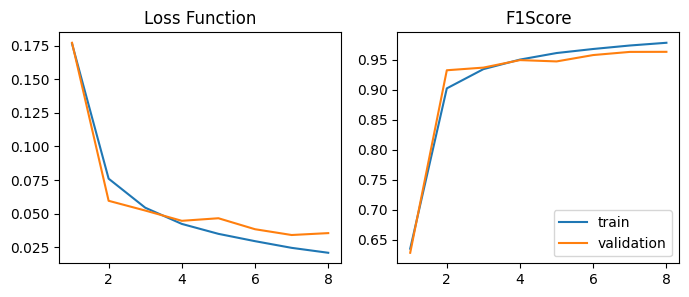

In [15]:
fig, plts = plt.subplots(1, 2)
fig.set_size_inches(8, 3)

steps = range(1, EPOCHS + 1)
plts[0].plot(steps, train_losses, label="train")
plts[0].plot(steps, val_losses, label="validation")
plts[0].set_title(label="Loss Function")

plts[1].plot(steps, train_metrics, label="train")
plts[1].plot(steps, val_metrics, label="validation")
plts[1].set_title(label="F1Score")
plts[1].legend()

### Postprocessing - Maximize F1-score

In [16]:
@torch.no_grad()
def predict(model, x):
    return F.sigmoid(model(x))

  0%|          | 0/169 [00:00<?, ?it/s]

Text(0.5, 1.0, 'BinaryF1Score by thresh value | best thresh = 0.549 | best = 0.9645630121231079')

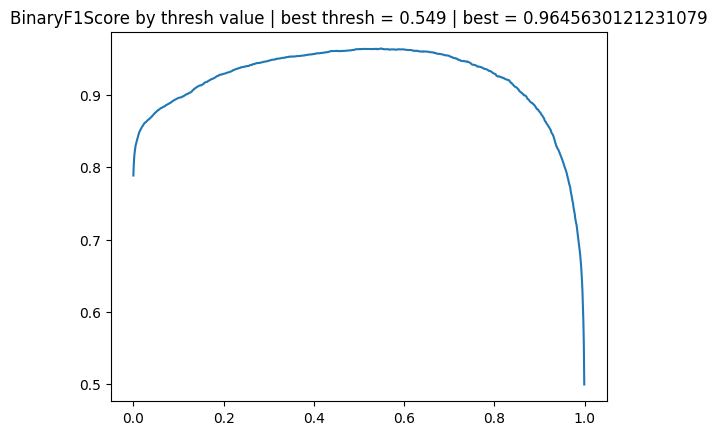

In [17]:
model.eval()
preds = np.empty(0)
truth = np.empty(0)

for x, y in tqdm(test_dataloader):
    y_pred = predict(model, x.to(DEVICE)).squeeze().cpu()
    preds = np.concatenate([preds, y_pred])
    truth = np.concatenate([truth, y])
    
thresholds = np.arange(0, 1, 1e-3)
results = []

for thresh in thresholds:
    results.append(
        metric(torch.FloatTensor(preds > thresh), torch.FloatTensor(truth)).item()
    )
    
best_thresh = thresholds[np.argmax(results)]
plt.plot(thresholds, results)
plt.title(f"{str(metric)[:-2]} by thresh value | best thresh = {round(best_thresh, 3)} | best = {max(results)}")

### Predictions

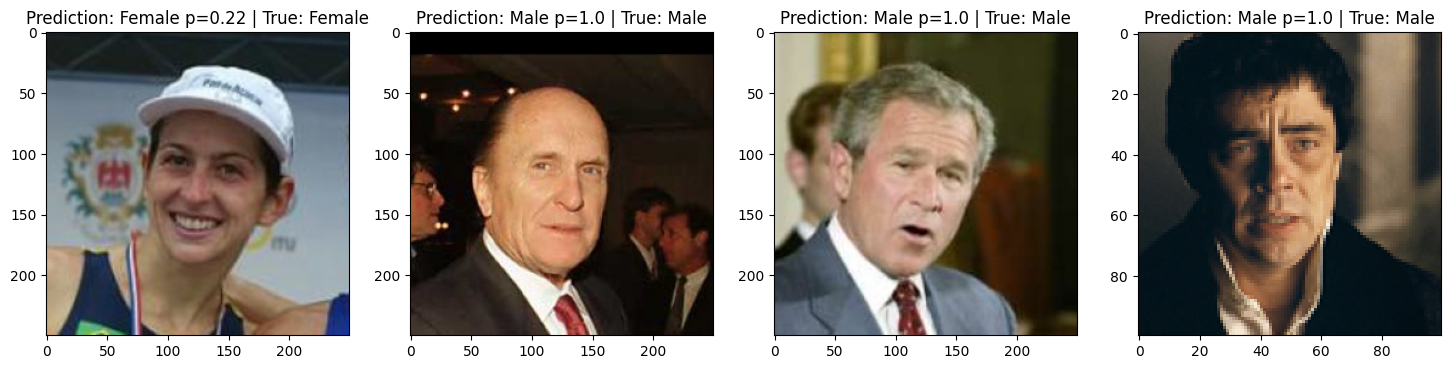

In [18]:
model.eval()
n_predictions = 4
fig, plts = plt.subplots(1, n_predictions)
fig.set_size_inches(18, 5)
torch.set_printoptions(precision=2)
for i in range(n_predictions):
    i_batch = np.random.randint(len(test_ds))
    inputs = test_ds[i_batch][0] / 255.
    target = test_ds[i_batch][1]
    inputs = torch.FloatTensor([inputs.tolist()]).to(DEVICE)
    p = float(predict(model, inputs).squeeze().cpu())
    y_pred = p > best_thresh
    plts[i].imshow(inputs[0].cpu().numpy().transpose((1, 2, 0)))
    gender_pred = "Male" if y_pred else "Female"
    gender_true = "Male" if target else "Female"
    plts[i].set_title(f"Prediction: {gender_pred} p={round(p, 2)} | True: {gender_true}")   